In [ ]:
# revisiting economics with Bayes
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

$$ \text{profit} = p \cdot D(p) - [ \text{varcost} \cdot D(p) + \text{fixedcost} ] $$

In [213]:
# true parameters
LATENT_ELASTICITY = -0.02
LATENT_SHAPE = 4.53
LATENT_STDEV = 0.25

# Set up the x values for the dataset
x = np.linspace(0, 200, 100)

# Calculate the y values based on a downward sloping curve function
y = np.exp(LATENT_ELASTICITY * x + LATENT_SHAPE)
noise = np.random.normal(0, 5, len(x))
y = y + noise

# replace any values less than or equal to 0 with 0.01
y[y <= 0] = 1.0

# plot an interactive curve over the plot with the formula y = a*x**-b
def plot_curve(a, b):
    plt.scatter(x, y)
    plt.plot(x, np.exp(a * x + b), c='r')
    # add a title to the plot and x and y labels
    plt.title('Demand Curve')
    plt.xlabel('price')
    plt.ylabel('quantity')
    plt.show()


# create an interactive plot using ipywidgest where the user can change the values of a and b
import ipywidgets as widgets
# set the start values to LATENT_ELASTICITY and LATENT_SHAPE
widgets.interact(plot_curve, a=widgets.FloatSlider(min=-1, max=0, step=0.01, value=LATENT_ELASTICITY), 
                                b=widgets.FloatSlider(min=0, max=10, step=0.01, value=LATENT_SHAPE));


interactive(children=(FloatSlider(value=-0.02, description='a', max=0.0, min=-1.0, step=0.01), FloatSlider(val…

In [214]:
# create a model in pymc for the demand curve

# take the log of y
y_log = np.log(y)

with pm.Model() as demand_model:
    # priors

    nu = pm.Normal('nu', mu=0.5, sigma=0.5)
    alpha = pm.Normal('alpha', mu=0, sigma=2)
    sd = pm.Exponential('sd', lam=1)
    
    # deterministic function
    y_hat = pm.math.dot(nu, x) + alpha

    #likelihood
    d_p = pm.Normal('demand', mu=y_hat, observed=y_log, sigma=sd)
    #prior_checks = pm.sample_prior_predictive(samples=50, random_seed=1546456)

    # run the model
    trace = pm.sample(1000, tune=1000, random_seed=1546456)


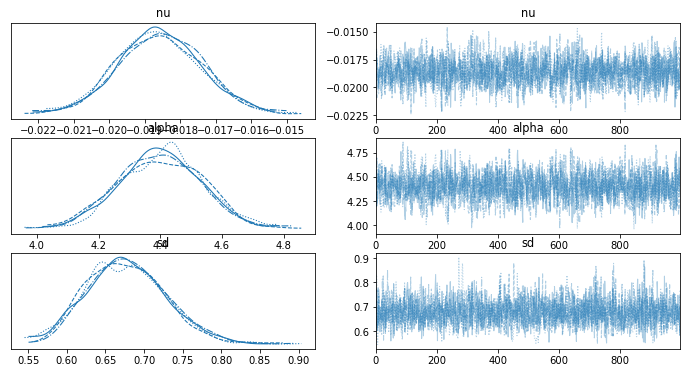

In [215]:
az.plot_trace(trace);

In [216]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,-0.02,0.00,-0.02,-0.02,0.0,0.0,1816.14,1770.17,1.0
alpha,4.40,0.14,4.14,4.63,0.0,0.0,1762.08,1745.38,1.0
sd,0.68,0.05,0.58,0.77,0.0,0.0,2056.58,1503.75,1.0


<AxesSubplot:xlabel='demand / demand'>

/Users/benjaminharder/miniconda3/envs/bda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


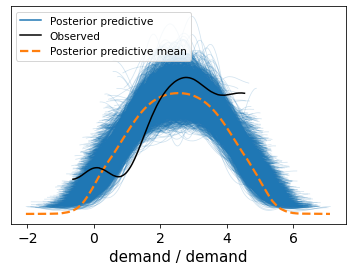

In [217]:
# plot a sample of the posterior curves over the data
# generate ppc samp
ppc = pm.sample_posterior_predictive(trace, model=demand_model)
# plot the results
az.plot_ppc(ppc)

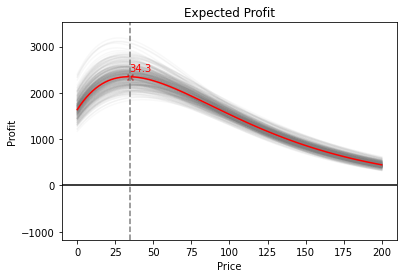

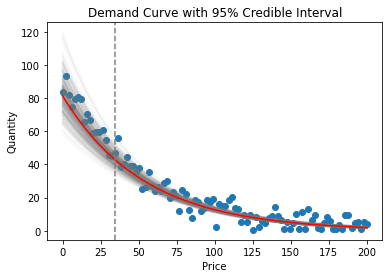

In [220]:
FIXED_COST = - 10
VAR_COST = - 20

nu = trace['posterior']['nu'][0].values
alpha = trace['posterior']['alpha'][0].values

# get the expected profit for each unit of x
# create an empty numpy array

for r in range(300):
    # loop through the x values
    Dp = np.array([])
    for i in x:
        # and calculate the expected quantity demanded    
        e_demand = np.exp(nu[r] * i + alpha[r])
        profit = i * e_demand - ((e_demand * VAR_COST) + FIXED_COST)
        # append to numpy array
        Dp = np.append(Dp, profit)

        # plot the expected demand curve
    plt.plot(x, Dp, c='grey', alpha=0.05)

Dp_mean = np.array([])
# draw a red line as the average profit across the curves
for i in x:
    # and calculate the expected quantity demanded    
    e_demand = np.exp(np.mean(nu) * i + np.mean(alpha))
    profit = i * e_demand - ((e_demand * VAR_COST) + FIXED_COST)
    # append to numpy array
    Dp_mean = np.append(Dp_mean, profit)

    # plot the expected demand curve
plt.plot(x, Dp_mean, c='r')

max_profit = np.max(Dp_mean)
max_x = x[np.argmax(Dp_mean)]

# limit the y axis to -100
plt.ylim(max_profit*-0.5, max_profit*1.50)
# draw a straight line at zero
plt.axhline(y=0, color='black', linestyle='-')


# find the maxium profit and mark it with a red X
plt.scatter(max_x, max_profit, c='r', marker='x')
# include the x and y values in parentheses within 2 decimal places
plt.text(max_x, max_profit * 1.05, f'{max_x:.1f}', c='r')
plt.axvline(x=max_x, color='grey', linestyle='--')
# add a title, and x and y axis labels
plt.title('Expected Profit')
plt.xlabel('Price')
plt.ylabel('Profit')
plt.show()

# for the first 100 samples plot the with the data
for i in range(300):
    plt.plot(x, np.exp(nu[i] * x + alpha[i]), c='grey', alpha=0.05)

# plot the mean values as a red line
plt.plot(x, np.exp(np.mean(nu) * x + np.mean(alpha)), c='r')
plt.scatter(x, y)
# add a vertical dashed grey line at the mean value of x
plt.axvline(x=max_x, color='grey', linestyle='--')

# add x and y axis
plt.xlabel('Price')
plt.ylabel('Quantity')
# add a title
plt.title('Demand Curve with 95% Credible Interval')
plt.show()

